# RAG Fusion
    - rewriting queries, and then filtering and ranking things
    - this will bridge the gap between "what users explicitly ask AND what they intend to ask"

# Methodology
    step 1 : use seperate LLM to rewrite queries (generate similar queries)
    step 2 : perform vector search on all queries
    step 3 : rank the retrivials using "Reciprocal Rank Fusion" (RRF)
    step 4 : rerank the results 
    step 5 : generate the output

# Solid Example

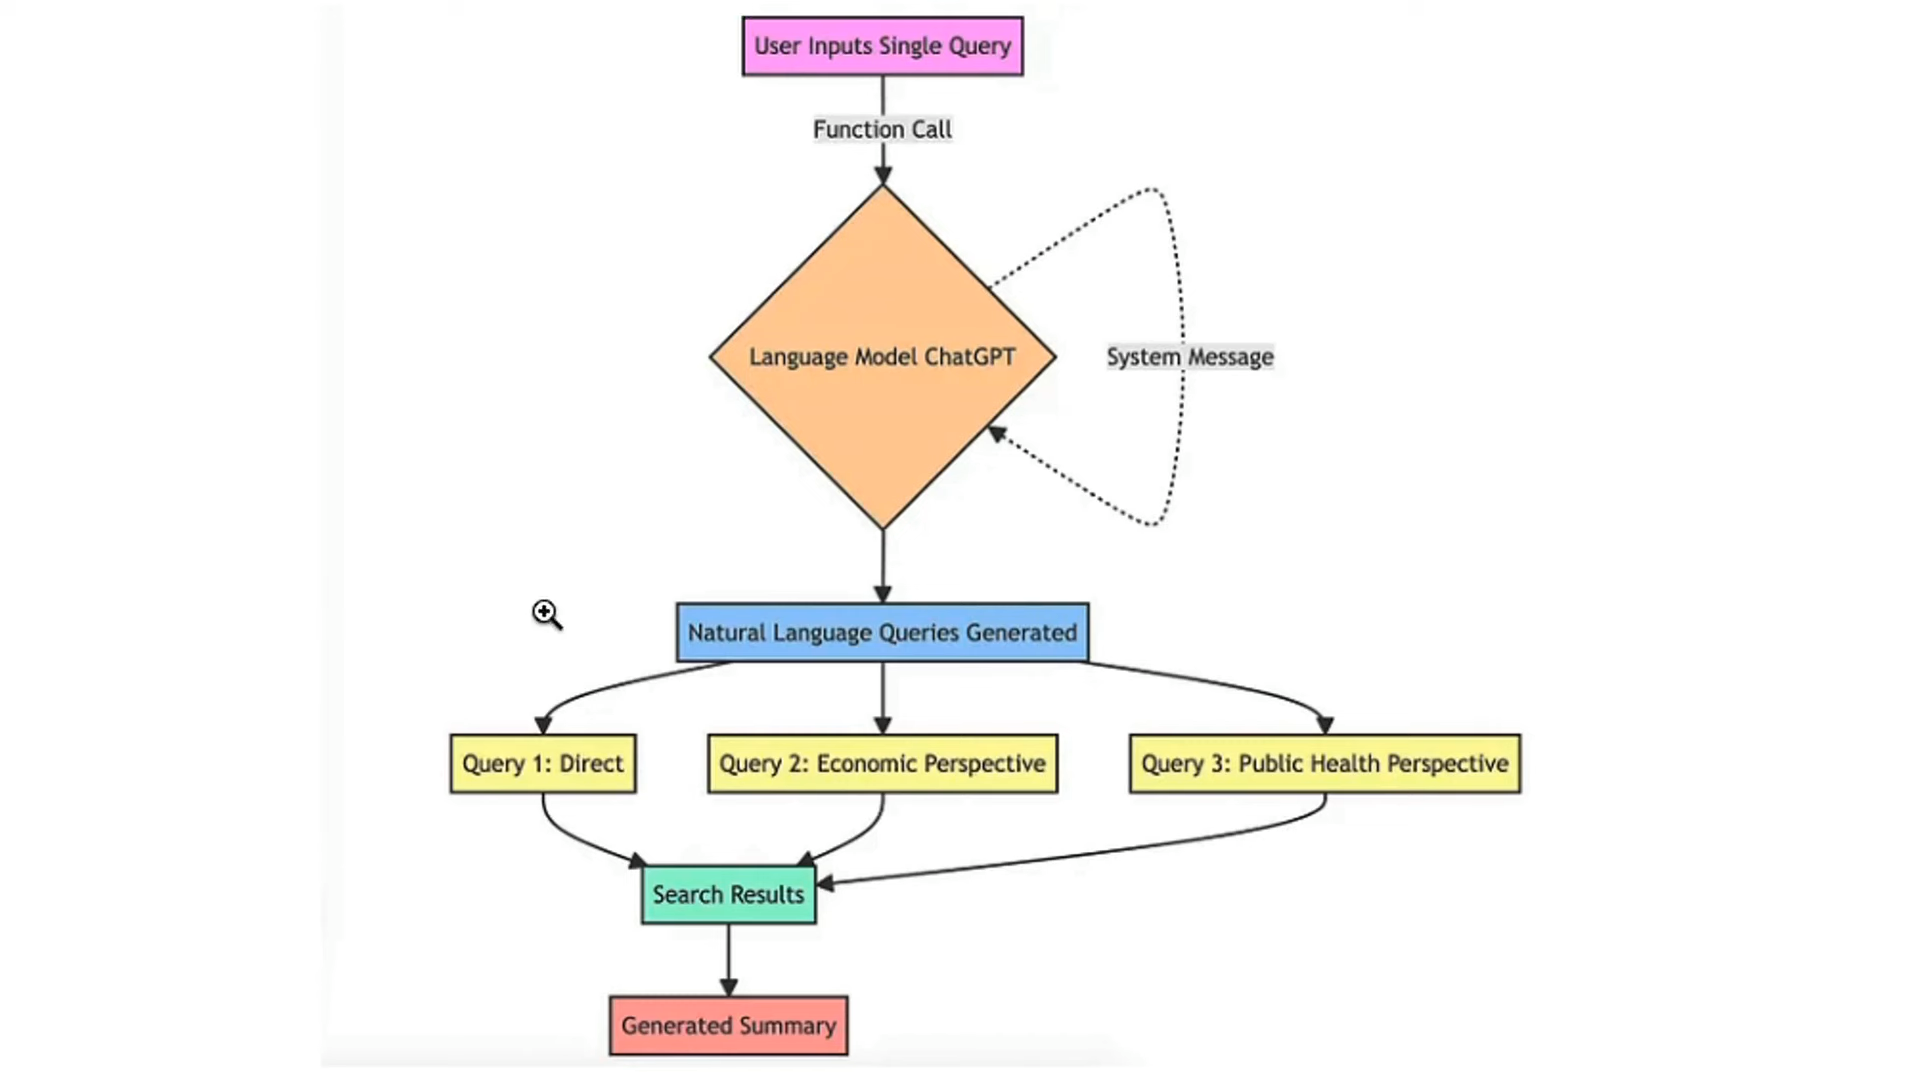

In [8]:
from langchain.load import dumps, loads
import chromadb
from langchain.vectorstores import Chroma
import yaml, os, textwrap, langchain
from chromadb.config import Settings
from langchain_google_genai import GoogleGenerativeAIEmbeddings, GoogleGenerativeAI
from langchain.chains import LLMChain, RetrievalQA
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain.schema.output_parser import StrOutputParser
from langchain.chat_models import ChatOpenAI, AzureChatOpenAI
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema.runnable import RunnableLambda, RunnablePassthrough
from langchain.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate, ChatMessagePromptTemplate, PromptTemplate

In [9]:
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

llm = GoogleGenerativeAI(
    model = "gemini-1.5-flash",google_api_key=os.environ["GOOGLE_API_KEY"])


client = chromadb.HttpClient(host="127.0.0.1", settings=Settings(allow_reset=True))
db = Chroma(client= client, embedding_function=embeddings)


retriever = db.as_retriever()

C:\Users\User\AppData\Local\Temp\ipykernel_19556\353745986.py:10: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  db = Chroma(client= client, embedding_function=embeddings)


In [10]:
query = "Tell me about retreival augmented generation?"

db.similarity_search(query, k=5)

[Document(metadata={'page': 6, 'source': 'pdf-docs\\RAG_survey_paper.pdf'}, page_content='Retrieval-Augmented Generation for Natural Language Processing: A Survey\nAlgorithm 4.3 Latent Fusions.\nInput: A query input 𝑞, top-𝑘nearest neighbors {𝑣1,...,𝑣 𝑘}, the encoder\nE, the generator Gcontaining 𝑙 pairs of modules {(M𝐴\n1 ,M𝐹\n1 ),... },\nwhere M𝐴\n𝑖 and M𝐹\n𝑖 are the attention module and the FFN module\nat layer 𝑖, M𝐶\n𝑖 is the cross-attention module used in attention-based\nlatent fusions.\nOutput: Generated response 𝑦.\n1: if Use the attention then\n2: ℎ𝐹\n0 = 𝑞;\n3: for 𝑖from 1 to 𝑙 do\n4: ℎ𝐴\n𝑖 = M𝐴\n𝑖 (ℎ𝐹\n𝑖−1 );\n5: 𝑒𝑣1 ,...,𝑒 𝑣𝑘 = E(𝑣1,...,𝑣 𝑘,ℎ𝐴\n𝑖 )\n6: ℎ𝑅\n𝑖 = M𝐶\n𝑖 (ℎ𝐴\n𝑖 ,𝑒𝑣1 ,...,𝑒 𝑣𝑘); /* Use a cross-attention module to\nincorporate external knowledge */\n7: ℎ𝐹\n𝑖 = M𝐹\n𝑖 (ℎ𝑅\n𝑖 )\n8: end for\n9: 𝑦= 𝐿𝑀_𝐻𝐸𝐴𝐷(ℎ𝐹\n𝑙 )\n10: else\n11: 𝑒𝑣1 ,...,𝑒 𝑣𝑘 = E(𝑣1,...,𝑣 𝑘)\n12: ℎ𝐹\n0 = 𝑞;\n13: for 𝑖from 1 to 𝑙 do\n14: ℎ𝐴\n𝑖 = M𝐴\n𝑖 (ℎ𝐹\n𝑖−1 );\n15: ℎ𝑅\n𝑖 = ℎ𝐴\n𝑖 +1\n𝑘\nÍ\n𝑗 𝑤𝑗𝑒𝑣𝑗 /* 

In [11]:
retriever = db.as_retriever(k=5)

# Basic Chat Chain

In [12]:
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

In [13]:
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [14]:
def wrap_text(text, width=90):
    lines = text.split('\n')
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]
    wrapped_text = '\n'.join(wrapped_lines)
    return wrapped_text

In [15]:
text_reply = chain.invoke("Tell me about Universal Studio Singapore")

print(wrap_text(text_reply))

This question cannot be answered from the given source.  The provided text discusses
Retrieval-Augmented Generation (RAG) in natural language processing,  mentions several
authors and publications, and includes snippets of text from books and websites, but
contains no information about Universal Studio Singapore.



# With RAG Fusion

In [16]:
prompt = ChatPromptTemplate(
                            input_variables=['original_query'], 
                            messages=[
                                    SystemMessagePromptTemplate(
                                                            prompt=PromptTemplate(
                                                                                input_variables=[], 
                                                                                template='You are a helpful assistant that generates multiple search queries based on a single input query.'
                                                                                )
                                                                ), 
                                    HumanMessagePromptTemplate(
                                                            prompt=PromptTemplate(
                                                                                input_variables=['original_query'], 
                                                                                template='Generate multiple search queries related to: {question} \n OUTPUT (4 queries):'
                                                                                )
                                                                )
                                    ])

In [17]:
generate_queries = (
    prompt | llm | StrOutputParser() | (lambda x: x.split("\n"))
)

In [18]:
def reciprocal_rank_fusion(results: list[list], k=60):
    fused_scores = {}
    for docs in results:
        for rank, doc in enumerate(docs):
            doc_str = dumps(doc)
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            fused_scores[doc_str] += 1 / (rank + k)

    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]
    return reranked_results

In [19]:
ragfusion_chain = generate_queries | retriever.map() | reciprocal_rank_fusion

In [20]:
langchain.debug = True

In [21]:
ragfusion_chain.input_schema.schema()

C:\Users\User\AppData\Local\Temp\ipykernel_19556\1611816459.py:1: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  ragfusion_chain.input_schema.schema()


{'properties': {'question': {'title': 'Question', 'type': 'string'}},
 'required': ['question'],
 'title': 'PromptInput',
 'type': 'object'}

In [23]:
ragfusion_chain.invoke({"question": "Tell me about retreival augmented generation?"}) # Generate queries

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "question": "Tell me about retreival augmented generation?"
}
[chain/start] [chain:RunnableSequence > prompt:ChatPromptTemplate] Entering Prompt run with input:
{
  "question": "Tell me about retreival augmented generation?"
}
[chain/end] [chain:RunnableSequence > prompt:ChatPromptTemplate] s] Exiting Prompt run with output:
[outputs]
[llm/start] [chain:RunnableSequence > llm:GoogleGenerativeAI] Entering LLM run with input:
{
  "prompts": [
    "System: You are a helpful assistant that generates multiple search queries based on a single input query.\nHuman: Generate multiple search queries related to: Tell me about retreival augmented generation? \n OUTPUT (4 queries):"
  ]
}
[llm/end] [chain:RunnableSequence > llm:GoogleGenerativeAI] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "1. \"Retrieval Augmented Generation (RAG) explained\"\n2. \"Retrieval Augmented Generation: advan

[(Document(metadata={'page': 12, 'source': 'pdf-docs\\RAG_survey_paper.pdf'}, page_content='Retrieval-Augmented Generation for Natural Language Processing: A Survey\nwhen to retrain/fine-tune the generator in RAG when new cor-\npus is added. Due to the in-context learning capability of exisitng\nLLM-based generators and high training overhead, retraining/fine-\ntuning the generator or directly inferring the generator becomes a\nchallenging choice for different scenarios. Recently, some efficient\ntraining strategies [28, 57] have been proposed to accelerate the\nfine-tuning process, which can be taken into considerations.\n9.5 Cross-Modality Retrieval\nRetrieving cross-modality information in NLP tasks can greatly\nenhance the quality and richness of the representations, leading\nto improved performance. First, cross-modality information, such\nas combining text with images, videos, or audio, provides a richer\ncontext to the content [58]. For instance, when language is ambigu-\nous, a

In [24]:
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

full_rag_fusion_chain = (
                        {
                            "context": ragfusion_chain,
                            "question": RunnablePassthrough()
                        }
                        | prompt
                        | llm
                        | StrOutputParser()
                        )

In [25]:
full_rag_fusion_chain.input_schema.schema()

C:\Users\User\AppData\Local\Temp\ipykernel_19556\1333827808.py:1: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  full_rag_fusion_chain.input_schema.schema()


{'properties': {'question': {'title': 'Question', 'type': 'string'},
  'root': {'title': 'Root'}},
 'required': ['question', 'root'],
 'title': 'RunnableParallel<context,question>Input',
 'type': 'object'}

In [28]:
full_rag_fusion_chain.invoke({"question": "Tell me about retreival augmented generation??"})

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "question": "Tell me about retreival augmented generation??"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<context,question>] Entering Chain run with input:
{
  "question": "Tell me about retreival augmented generation??"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<context,question> > chain:RunnableSequence] Entering Chain run with input:
{
  "question": "Tell me about retreival augmented generation??"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<context,question> > chain:RunnableSequence > prompt:ChatPromptTemplate] Entering Prompt run with input:
{
  "question": "Tell me about retreival augmented generation??"
}
[chain/end] [chain:RunnableSequence > chain:RunnableParallel<context,question> > chain:RunnableSequence > prompt:ChatPromptTemplate] s] Exiting Prompt run with output:
[outputs]
[llm/start] [chain:RunnableSequence > chain:RunnableParallel<conte

"Retrieval-Augmented Generation (RAG) leverages an external knowledge database to augment Large Language Models (LLMs).  RAG typically consists of three modules: a retriever, a generator, and retrieval fusions.  The retriever encodes inputs into embeddings, uses an efficient indexing system (like IVF, HNSW, or tree-based indexing) for approximate nearest neighbor search, and stores external knowledge in a datastore (e.g., LMDB or RocksDB) as key-value pairs.  The main challenge in the retriever is balancing retrieval efficiency and quality.  Retrieval fusions use techniques like query-based fusion (augmenting inputs with retrievals), logits-based fusion (fusing retrieval logits with generator output logits), or latent fusion (introducing retrieval representations into the generator's latent representations) to incorporate retrieved information.  Generators can be default LLMs (like GPT, Mistral, Gemini, Llama, GLM) or retrieval-augmented generators with added modules.  RAG addresses LL